The aim of this project is to provide a practical overview of the general DS/ML workflow, which is becoming an increasingly popular framework upon which modern-day actuarial pricing methods are being built. Accurate pricing is currently one of the most crucial challenges that businesses across the insurance industry are facing, where providing accurate estimates of loss costs is vital to ensuring prudent insurance portfolio management and maintaining successful financial performance, especially as the sector is currently experiencing a swelling volume of claims - for example, regarding business interruption - as one of the major consequences of COVID-19.

As a case study, we will introduce some supervised ML techniques for predicting claim severities on a French motor third-party liability (MTPL) insurance dataset.

In [1]:
# Import key modules that will be used throughout the project.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting
import seaborn as sns

In [4]:
MTPLFREQ = pd.read_csv('freMTPLfreq.csv')
MTPLSEV = pd.read_csv('freMTPLsev.csv')

In [5]:
MTPLFREQ.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


In [6]:
MTPLSEV.head()

,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905
2,314463,1150
3,318713,1220
4,309380,55077


In [7]:
# Check for total amount of claims paid in original DataFrame, prior to merging MTPLfreq with MTPLsev
MTPLSEV['ClaimAmount'].sum()

34465077

In [10]:
# Aggregate the claim amounts by PolicyID, prior to merging MTPLfreq with MTPLsev.
MTPLSEV.groupby(['PolicyID'])[['ClaimAmount']].agg('sum').reset_index()

,PolicyID,ClaimAmount
0,33,302
1,41,2001
2,92,1449
3,96,10870
4,142,1390
...,...,...
15385,412262,1426
15386,412270,1364
15387,412664,7603
15388,412926,1751


In [13]:
# Perform an outer merge between MTPLfreq/MTPLsev, based on PolicyID, then reset the index back to PolicyID (this is dropped during merging).
df_merged = pd.merge(MTPLFREQ, MTPLSEV, how='outer', on='PolicyID').fillna(0).set_index('PolicyID')

In [14]:
df_merged['ClaimAmount'].sum()

34465077.0

## EDA

In [15]:
df_merged.columns

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas',
       'Region', 'Density', 'ClaimAmount'],
      dtype='object')

In [16]:
df_merged.dtypes

ClaimNb          int64
Exposure       float64
Power           object
CarAge           int64
DriverAge        int64
Brand           object
Gas             object
Region          object
Density          int64
ClaimAmount    float64
dtype: object

In [17]:
df_merged.head(5)

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
PolicyID,,,,,,,,,,
1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


How many policyholders have made zero claims? How will this affect the choice of model that we use to estimate claim severity?

In [26]:
policies_no_claim = len(df_merged.loc[df_merged['ClaimNb']==0].index)
all_policies = len(df_merged.index)

pct_policy_no_claim = round((policies_no_claim/all_policies) * 100, 2)

In [27]:
pct_policy_no_claim

96.09

96.09% of policyholders have not made any claims.

As a vast majority of the policyholders have not made any claims whatsoever, this implies that ClaimAmount will have a distribution that peaks at zero, but also features right-skewness/tailing to account for positive (total) claim amounts with exponentially decaying probability.

Hence, the linear regression model that we use/choose will need to be able to sufficiently account for both of these characteristics of the distribution of ClaimAmount

### Generate additional features based on interactions/transformations of existing variable

Here, we create two new variables based on existing features - these are ClaimFreq and ClaimSev, which represent the frequency and severity of a policyholder's claim/s, respectively, in units of policy exposure. However, one of these features is not appropriate for use in model training - we will discuss this further

In [28]:
df_merged['ClaimFreq'] = df_merged['ClaimNb'] / df_merged['Exposure']

df_merged['ClaimSev'] = df_merged['ClaimAmount'] / df_merged['Exposure']

Next, we will consider where data leakage may be likely to creep into the model fitting process, by reviewing the features/columns to confirm their meanings and evaluate whether any of them can introduce bias into the model training process. In this project, the following two factors are considered to be relevant:

Target leakage

This can occur when the predictors/features include or refer to data/information that will not be available at the time of making predictions. In this project, any features that are derived from the target that we wish to predict (e.g. ClaimSev) are not suitable - this is because ClaimSev itself depends on ClaimAmount, which we will not know at the time of prediction.

Train-test contamination

This can occur when data that are used to train the model/s are subsequently used to make predictions, which will lead to the introduction of bias in the model evaluation process; once trained, the model will appear to perform extremely well against the (in-sample) test dataset, but will be worse at generalising to unseen/out-of-sample data.

Hence, using train_test_split() to split our dataset into training/test samples is vital for avoiding train-test contamination of the model training process.

# train-test split

we will create separate DataFrames that will store the features and target variables. These are then supplied to the sklearn function train_test_split() in order to split the data into training/test subsets, for the reason outlined above.

In [30]:
y_full = df_merged.ClaimAmount

# Assign the features to their own dataframe. Also, remove ClaimSev, to prevent data leakage when predicting ClaimAmount.
X_full = df_merged.drop(['ClaimAmount', 'ClaimSev'], axis=1)


In [31]:
y_full.head(5)

PolicyID
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: ClaimAmount, dtype: float64

In [32]:
X_full.head(5)

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimFreq
PolicyID,,,,,,,,,,
1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


In [33]:
# Perform a train-test split to obtain the training and test data as separate dataframes.
from sklearn.model_selection import train_test_split

In [34]:
# We will set the size of the X/y training datasets to be 80% of the original (full) X/y datasets, via the train_size/test_size parameters
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.2, random_state=1)

### Label Encoding

Here, we label-encode the Power column such that it changes each (ordinal) text-based label to a numerical value which is machine-interpretable, for later use in feature scaling as well as model fitting.

In [35]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the training/validation feature subsets to avoid changing any original data.
copy_X_train = X_train.copy()
copy_X_valid = X_valid.copy()

In [36]:
df_merged.Power.unique()

array(['g', 'f', 'd', 'i', 'e', 'h', 'j', 'l', 'o', 'n', 'k', 'm'],
      dtype=object)

In [39]:
df_merged.Brand.unique()

array(['Japanese (except Nissan) or Korean', 'Fiat',
       'Opel, General Motors or Ford', 'Mercedes, Chrysler or BMW',
       'Renault, Nissan or Citroen', 'Volkswagen, Audi, Skoda or Seat',
       'other'], dtype=object)

In [40]:
df_merged.Gas.unique()

array(['Diesel', 'Regular'], dtype=object)

In [41]:
df_merged.Region.unique()

array(['Aquitaine', 'Nord-Pas-de-Calais', 'Pays-de-la-Loire',
       'Ile-de-France', 'Centre', 'Poitou-Charentes', 'Bretagne',
       'Basse-Normandie', 'Limousin', 'Haute-Normandie'], dtype=object)

In [37]:
# Apply a label encoder to the 'Power' column (i.e. encoding of ordinal variable).
label_encoder = LabelEncoder()
copy_X_train['Power'] = label_encoder.fit_transform(X_train['Power'])
copy_X_valid['Power'] = label_encoder.transform(X_valid['Power'])

### One-Hot Encoding

We also one-hot encode the Brand, Gas and Region columns, such that these categories are converted to numerical and machine-interpretable values that can be supplied to each regression model.

In [38]:
copy_X_train

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimFreq
PolicyID,,,,,,,,,,
262972,0,0.24,2,11,26,"Volkswagen, Audi, Skoda or Seat",Diesel,Centre,16,0.0
316568,0,0.42,1,4,34,"Renault, Nissan or Citroen",Diesel,Nord-Pas-de-Calais,684,0.0
266894,0,0.43,2,5,30,"Renault, Nissan or Citroen",Diesel,Nord-Pas-de-Calais,7887,0.0
186466,0,1.00,2,9,58,"Opel, General Motors or Ford",Regular,Poitou-Charentes,25,0.0
167265,0,1.00,2,15,63,"Renault, Nissan or Citroen",Regular,Centre,32,0.0
...,...,...,...,...,...,...,...,...,...,...
73213,0,1.00,2,10,59,"Opel, General Motors or Ford",Regular,Poitou-Charentes,227,0.0
370705,0,0.62,4,18,46,"Renault, Nissan or Citroen",Diesel,Centre,27,0.0
311611,0,0.25,3,1,39,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,3661,0.0


In [43]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols = ['Brand', 'Gas', 'Region']

## We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented
## in the training data, and setting sparse=False ensures that the encoded columns are returned as a numpy array
## (instead of a sparse matrix).

oh_cols_train = pd.DataFrame(oh_encoder.fit_transform(copy_X_train[oh_cols]))
oh_cols_valid = pd.DataFrame(oh_encoder.transform(copy_X_valid[oh_cols]))

In [46]:
# One-hot encoding removes the index; re-assign the original index.
oh_cols_train.index = copy_X_train.index
oh_cols_valid.index = copy_X_valid.index

In [56]:
oh_cols_train.columns = oh_encoder.get_feature_names_out(oh_cols)
oh_cols_valid.columns = oh_encoder.get_feature_names_out(oh_cols)

# Create copies that only include numerical feature columns (these will be replaced with one-hot encoded versions).
copy_X_train_no_oh_cols = copy_X_train.drop(oh_cols, axis=1)
copy_X_valid_no_oh_cols = copy_X_valid.drop(oh_cols, axis=1)

# Concatenate the one-hot encoded columns with the existing numerical feature columns.
X_train_enc = pd.concat([copy_X_train_no_oh_cols, oh_cols_train], axis=1)
X_valid_enc = pd.concat([copy_X_valid_no_oh_cols, oh_cols_valid], axis=1)

### Data scaling - normalisation

Next, we perform min-max scaling on the encoded dataset, such that all features lie between 0 and 1 - this is so that, when training any of the regression models, all features will have variances with the same order of magnitude as each other. Thus, no single feature will dominate the objective function and prohibit the model from learning from other features correctly as expected.

In [61]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
mmscaler.fit(X_train_enc)

# Fit the scaler, then normalise/transform both the training and validation feature datasets.
X_train_scale = pd.DataFrame(mmscaler.transform(X_train_enc),
                             index=X_train_enc.index,
                             columns=X_train_enc.columns)

# Fit the scaler, then normalise/transform both the training and validation feature datasets.
X_valid_scale = pd.DataFrame(mmscaler.transform(X_valid_enc),
                             index=X_valid_enc.index,
                             columns=X_valid_enc.columns)

In [65]:
# Verify minimum value of all features in X_train_scale:

X_valid_scale.min(axis=0)

ClaimNb                                     0.0
Exposure                                    0.0
Power                                       0.0
CarAge                                      0.0
DriverAge                                   0.0
Density                                     0.0
ClaimFreq                                   0.0
Brand_Fiat                                  0.0
Brand_Japanese (except Nissan) or Korean    0.0
Brand_Mercedes, Chrysler or BMW             0.0
Brand_Opel, General Motors or Ford          0.0
Brand_Renault, Nissan or Citroen            0.0
Brand_Volkswagen, Audi, Skoda or Seat       0.0
Brand_other                                 0.0
Gas_Diesel                                  0.0
Gas_Regular                                 0.0
Region_Aquitaine                            0.0
Region_Basse-Normandie                      0.0
Region_Bretagne                             0.0
Region_Centre                               0.0
Region_Haute-Normandie                  

In [67]:
# Verify minimum value of all features in X_train_scale:

X_train_scale.max(axis=0)

ClaimNb                                     1.0
Exposure                                    1.0
Power                                       1.0
CarAge                                      1.0
DriverAge                                   1.0
Density                                     1.0
ClaimFreq                                   1.0
Brand_Fiat                                  1.0
Brand_Japanese (except Nissan) or Korean    1.0
Brand_Mercedes, Chrysler or BMW             1.0
Brand_Opel, General Motors or Ford          1.0
Brand_Renault, Nissan or Citroen            1.0
Brand_Volkswagen, Audi, Skoda or Seat       1.0
Brand_other                                 1.0
Gas_Diesel                                  1.0
Gas_Regular                                 1.0
Region_Aquitaine                            1.0
Region_Basse-Normandie                      1.0
Region_Bretagne                             1.0
Region_Centre                               1.0
Region_Haute-Normandie                  

In [73]:
#Here, we use the pd.describe() function to obtain descriptive statistics of the original dataset (prior to preprocessing).
print(df_merged.describe())

             ClaimNb       Exposure         CarAge      DriverAge  \
count  413960.000000  413960.000000  413960.000000  413960.000000   
mean        0.043089       0.561368       7.531435      45.317393   
std         0.223188       0.369401       5.761992      14.332686   
min         0.000000       0.002732       0.000000      18.000000   
25%         0.000000       0.200000       3.000000      34.000000   
50%         0.000000       0.540000       7.000000      44.000000   
75%         0.000000       1.000000      12.000000      54.000000   
max         4.000000       1.990000     100.000000      99.000000   

             Density   ClaimAmount      ClaimFreq      ClaimSev  
count  413960.000000  4.139600e+05  413960.000000  4.139600e+05  
mean     1987.325519  8.325702e+01       0.128651  3.704311e+02  
std      4779.598311  4.184730e+03       2.279562  3.471498e+04  
min         2.000000  0.000000e+00       0.000000  0.000000e+00  
25%        67.000000  0.000000e+00       0.00000

Next, we will generate pairplots between the targets and features to understand the relationships between them and discover whether there are any trends/correlations within the data. To do this, we will use the seaborn.pairplot() function as a high-level interface to plot the pairwise relationships in the df_merged dataset.

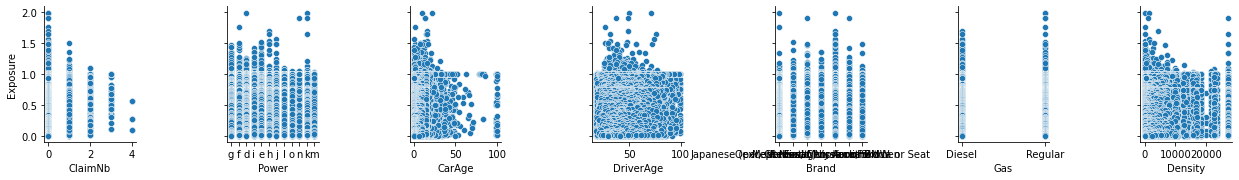

In [74]:
desc_pairplot_x_vars_A = ['ClaimNb', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']

desc_pairplot_x_vars_B = ['Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']


desc_pairplot_1 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_A, y_vars='Exposure')

ClaimNb: The trend in this graph implies that policyholders with higher claim frequencies tend to be covered on policies with shorter exposure periods (this view may, however, be affected by renewals/binders).

Power: The trend in this graph implies that cars covered by policies with longer exposure periods tend to be less powerful, although there appear to be some high-powered cars (e.g. categories k/n) that go against this pattern.

CarAge: The trend in this graph implies that a vast majority of the cars insured have 1-year exposure periods, with a wider spread of policy exposure periods in the range of years lower than 25 (i.e. relatively young cars).

DriverAge: This graph shows a wide distribution of exposure periods across drivers of different ages, with a range of middle-aged policyholders that are insured with exposure periods longer than 1 year.

Brand: This graph does not show any clear correlation or trend between the exposure period of the MTPL policy and the brand of the car that is insured.

Gas: This graph does not show any clear correlation or trend between the exposure period of the MTPL policy and the fuel type of the car that is insured.

Density: This graph shows a wide distribution of policy exposure periods, which appears to decrease as the population density of the area that the policyholder inhabits increases; however, this distribution does feature some observations at higher values of Density.

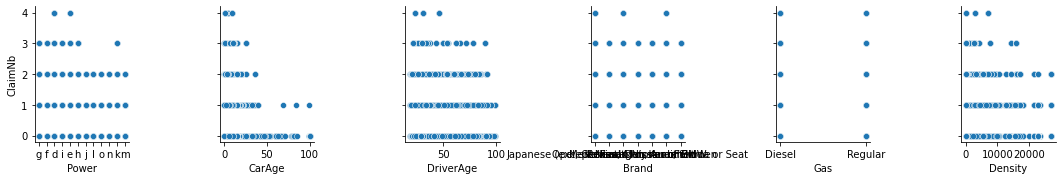

In [75]:
desc_pairplot_2 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimNb')

Power: The trend in this graph implies that policyholders who are in the upper quartile of claim frequency (i.e. N > 3) tend to drive less powerful/average cars, however there does not appear to be any general correlation between car power and claim frequency, among the majority of other policyholders.

CarAge: The trend in this graph implies that a majority of the variance in ClaimNb is shown across cars that are younger than 50; the number of claims per policyholder tends to decrease with the age of the car.

DriverAge: This graph shows a wide distribution of claim frequencies across drivers of different ages, with no clear trend between the age of the policyholder and the number of claims that they have made.

Brand: This graph does not show any clear correlation or trend between the number of claims made and the brand of the car owned by the (insured) policyholder.

Gas: This graph also does not show any clear correlation between the number of claims made and the fuel type of the car that is insured.

Density: This graph shows the general trend that the number of claims per policyholder decreases as the population density (of the town/city that they live in) increases.


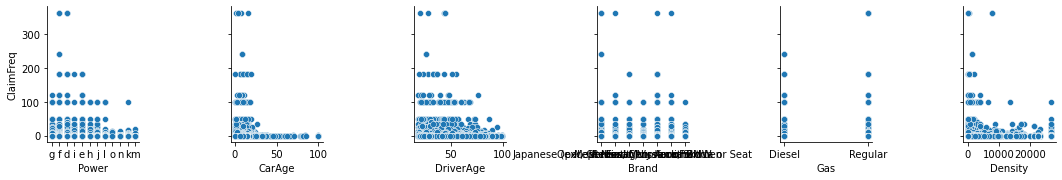

In [78]:
desc_pairplot_3 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimFreq')

### Perform feature selection via L1 regularisation
Next, we will perform feature selection via L1 (lasso) regularisation, in order to reduce the number of features that are used for fitting each of the models - this is done in order to prevent overfitting. To do this, we add a regularisation term (containing the L1 norm) to the standard loss function that is to be minimised, such that:

Loss=Error(y,y^)+λ∑i=1N|wi|
 
Where:

y
  is the true value/severity of the claim
y^
  is the claim value/severity predicted by the model
λ>0
  is the regularisation parameter that determines the strength of regularisation to be applied to the loss function
wi
  is the weight of feature  i

In [80]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [83]:
lasso = Lasso(alpha=5e-5, random_state=1, max_iter=1e+6).fit(X_train_scale, y_train)
model = SelectFromModel(lasso, prefit=True)

X_train_l1 = model.transform(X_train_scale)

selected_features = pd.DataFrame(model.inverse_transform(X_train_l1),
                                index=X_train_scale.index,
                                columns=X_train_scale.columns)

print(selected_features)

          ClaimNb  Exposure     Power  CarAge  DriverAge   Density  ClaimFreq  \
PolicyID                                                                        
262972        0.0  0.119394  0.181818    0.11   0.098765  0.000519        0.0   
316568        0.0  0.209971  0.090909    0.04   0.197531  0.025261        0.0   
266894        0.0  0.215003  0.181818    0.05   0.148148  0.292059        0.0   
186466        0.0  0.501829  0.181818    0.09   0.493827  0.000852        0.0   
167265        0.0  0.501829  0.181818    0.15   0.555556  0.001111        0.0   
...           ...       ...       ...     ...        ...       ...        ...   
73213         0.0  0.501829  0.181818    0.10   0.506173  0.008334        0.0   
370705        0.0  0.310611  0.363636    0.18   0.345679  0.000926        0.0   
311611        0.0  0.124426  0.272727    0.01   0.259259  0.135529        0.0   
266811        0.0  0.456540  0.090909    0.07   0.271605  0.001704        0.0   
127768        0.0  0.124426 

C:\Users\shubham.rangate\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [84]:
selected_columns = selected_features.columns[selected_features.var() != 0]
print(selected_columns)

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Density',
       'ClaimFreq', 'Brand_Fiat', 'Brand_Japanese (except Nissan) or Korean',
       'Brand_Opel, General Motors or Ford',
       'Brand_Renault, Nissan or Citroen',
       'Brand_Volkswagen, Audi, Skoda or Seat', 'Brand_other', 'Gas_Diesel',
       'Region_Basse-Normandie', 'Region_Bretagne', 'Region_Centre',
       'Region_Haute-Normandie', 'Region_Ile-de-France', 'Region_Limousin',
       'Region_Nord-Pas-de-Calais', 'Region_Pays-de-la-Loire',
       'Region_Poitou-Charentes'],
      dtype='object')


In [89]:
X_train_l1 = selected_features[selected_columns]

In [92]:
X_valid_l1 = X_valid_scale[selected_columns]

In [90]:
X_train_l1.head()

,ClaimNb,Exposure,Power,CarAge,DriverAge,Density,ClaimFreq,Brand_Fiat,Brand_Japanese (except Nissan) or Korean,"Brand_Opel, General Motors or Ford",...,Gas_Diesel,Region_Basse-Normandie,Region_Bretagne,Region_Centre,Region_Haute-Normandie,Region_Ile-de-France,Region_Limousin,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Poitou-Charentes
PolicyID,,,,,,,,,,,,,,,,,,,,,
262972,0.0,0.119394,0.181818,0.11,0.098765,0.000519,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
316568,0.0,0.209971,0.090909,0.04,0.197531,0.025261,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
266894,0.0,0.215003,0.181818,0.05,0.148148,0.292059,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
186466,0.0,0.501829,0.181818,0.09,0.493827,0.000852,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
167265,0.0,0.501829,0.181818,0.15,0.555556,0.001111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## MODEL BUILDING

In this project, we aim to predict the target (ClaimAmount) using the following linear regression approaches:

1. Random Forest Regression
Random Forest Regression works by training multiple decision trees, based on the random sampling (with replacement) of a training dataset. Input features from an unseen dataset can then be supplied to each trained decision tree in order to generate a prediction, which is subsequently averaged across all predictions to produce a final regression output; averaging across all predictions has the benefit of reducing overfitting to any given random sample within the training set.

2. Poisson (GLM) Regression
Poisson Regression works in a very similar way to ordinary linear regression, except here we assume that the response variable (ClaimAmount) has a Poisson distribution - thus forming one of two generalised linear models (GLMs) that we will use in this project:
    Yi∼iidPois(λ)
 
This model is chosen purely as the first example of a GLM with a positive continuous distribution that can be used to predict claim severity, although there are better alternatives to use.

3. Tweedie (GLM) Regression
Tweedie Regression, like Poisson regression, also assumes that the response variable follows a non-normal distribution - in this case, we assume that ClaimAmount has a Tweedie distribution:

Y=∑i=1TXi,T∼Pois(λ),Xi∼iidGa(α,γ),T⊥Xi

Where  Y
  is the aggregate claim amount for a covered risk,  T
  is the number of reported claims and  Xi
  is the insurance payment for the  ith
  claim.

However, the Tweedie distribution is special in that it is an example of a compound Poisson-Gamma distribution, which means that the distribution shows a mix between both Poisson and Gamma form. The Poisson component helps to account for the large positive mass at zero (i.e. where ClaimAmount is 0, as most policyholders do not make any claims), however the Gamma component allows for a continuous, positively skewed, tail-shaped distribution associated with exponentially decaying probability density (i.e. higher claim severities can also be accounted for).

4. XGBoost (eXtreme Gradient Boosting) Regression
XGBoost Regression works similarly to random forest regression, however it is based on an iterative process of gradually reducing the error between predicted & true values. This is achieved by building a new decision tree to fit on the pseudo-residuals of the previous tree, allowing the algorithm to "learn" and iteratively refine the regression model until the objective loss function is sufficiently minimised. This can be performed using gradient descent optimisation algorithms; XGBoost is one example of a gradient descent method, and is widely implemented due to its effectiveness in this context.



In [93]:
!pip install xgboost

# Model Building

### Cross validation

In [115]:
# Import the regression models from sklearn/xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score

In [116]:
## Define scoring functions for each method.

def get_score_RF(n_estimators):
    model_RF = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    scores_RF = -1 * cross_val_score(model_RF, X_train_l1, y_train ,cv=5,scoring='neg_mean_absolute_error')
    return scores_RF.mean()


def get_score_PGLM(alpha):
    model_PGLM = PoissonRegressor(alpha=alpha, max_iter=500)  
    scores_PGLM = -1 * cross_val_score(model_PGLM, X_train_l1, y_train,cv=5,scoring='neg_mean_absolute_error')
    return scores_PGLM.mean()


def get_score_TGLM(alpha):
    model_TGLM = TweedieRegressor(power=1.8, alpha=alpha, max_iter=500) 
    scores_TGLM = -1 * cross_val_score(model_TGLM, X_train_l1, y_train,cv=5,scoring='neg_mean_absolute_error')
    return scores_TGLM.mean()


def get_score_XGB(n_estimators):
    model_XGB = XGBRegressor(n_estimators=n_estimators,
                               learning_rate=0.01,
                               random_state=1)
    scores_XGB = -1 * cross_val_score(model_XGB, X_train_l1, y_train,
                                     cv=5,
                                     scoring='neg_mean_absolute_error') 
    return scores_XGB.mean()


## Create empty dictionaries which will be used to store the scoring results for each method.

results_RF = {}
results_PGLM = {}
results_TGLM = {}
results_XGB = {}

In [117]:
## Obtain 8 scores for the RandomForestRegressor model.

for i in range(1, 9):
    results_RF[100*i] = get_score_RF(100*i)
    print("results_RF{} recorded".format(i))

print("RF done")

results_RF1 recorded
results_RF2 recorded
results_RF3 recorded
results_RF4 recorded
results_RF5 recorded
results_RF6 recorded
results_RF7 recorded
results_RF8 recorded
RF done


In [118]:
for i in range(1, 9):
    results_PGLM[round(0.2*i, 2)] = get_score_PGLM(round(0.2*i, 2))
    print("results_PGLM{} recorded".format(i))

print("PGLM done")

results_PGLM1 recorded
results_PGLM2 recorded
results_PGLM3 recorded
results_PGLM4 recorded
results_PGLM5 recorded
results_PGLM6 recorded
results_PGLM7 recorded
results_PGLM8 recorded
PGLM done


In [119]:
# Obtain 8 scores for the TweedieRegressor model.

for i in range(1, 9):
    results_TGLM[round(0.01*i, 2)] = get_score_TGLM(round(0.01*i, 2))
    print("results_TGLM{} recorded".format(i))

print("TGLM done")

results_TGLM1 recorded
results_TGLM2 recorded
results_TGLM3 recorded
results_TGLM4 recorded
results_TGLM5 recorded
results_TGLM6 recorded
results_TGLM7 recorded
results_TGLM8 recorded
TGLM done


In [120]:
#Obtain 8 scores for the XGBRegressor model.

for i in range(1, 9):
    results_XGB[5*i] = get_score_XGB(5*i)
    print("results_XGB{} recorded".format(i))
    
print("XGB done")

results_XGB1 recorded
results_XGB2 recorded
results_XGB3 recorded
results_XGB4 recorded
results_XGB5 recorded
results_XGB6 recorded
results_XGB7 recorded
results_XGB8 recorded
XGB done


In [121]:
RF_n_estimators_best = min(results_RF, key=results_RF.get)
print(RF_n_estimators_best)

300


In [122]:
PGLM_alpha_best = min(results_PGLM, key=results_PGLM.get)
print(PGLM_alpha_best)

1.6


In [123]:
TGLM_alpha_best = min(results_TGLM, key=results_TGLM.get)
print(TGLM_alpha_best)

0.05


In [124]:
XGB_n_estimators_best = min(results_XGB, key=results_XGB.get)
print(XGB_n_estimators_best)

40


In [125]:
# Model trining

# Define the optimised regression models that will be used.

model_RF_opt = RandomForestRegressor(n_estimators=RF_n_estimators_best, random_state=1, n_jobs=-1)

model_PGLM_opt = PoissonRegressor(alpha=PGLM_alpha_best, max_iter=500)

model_TGLM_opt = TweedieRegressor(power=1.8, alpha=TGLM_alpha_best, max_iter=500)

model_XGB_opt = XGBRegressor(n_estimators=XGB_n_estimators_best, learning_rate=0.01, random_state=1)

In [126]:
# Fit the optimised models to the full (pre-processed) training dataset.

model_RF_opt.fit(X_train_l1, y_train)
print("model_RF_opt trained")

model_PGLM_opt.fit(X_train_l1, y_train)
print("model_PGLM_opt trained")

model_TGLM_opt.fit(X_train_l1, y_train)
print("model_TGLM_opt trained")

model_XGB_opt.fit(X_train_l1, y_train)
print("model_XGB_opt trained")

model_RF_opt trained
model_PGLM_opt trained
model_TGLM_opt trained
model_XGB_opt trained


In [127]:
# Use the trained models to generate unique sets of predicted y-values i.e. ClaimAmount.

preds_RF = model_RF_opt.predict(X_valid_l1)
preds_PGLM = model_PGLM_opt.predict(X_valid_l1)
preds_TGLM = model_TGLM_opt.predict(X_valid_l1)
preds_XGB = model_XGB_opt.predict(X_valid_l1)
print("All predictions generated")

All predictions generated


## Model Evaluation

In [128]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error metric for each set of predicted y-values.

MAE_RF = mean_absolute_error(y_valid, preds_RF)
MAE_PGLM = mean_absolute_error(y_valid, preds_PGLM)
MAE_TGLM = mean_absolute_error(y_valid, preds_TGLM)
MAE_XGB = mean_absolute_error(y_valid, preds_XGB)
print("All MAE scores calculated")

All MAE scores calculated


In [129]:
# Collect all MAE scores in a single dictionary.

MAE_results = {'RF': MAE_RF,
                'PGLM': MAE_PGLM,
                'TGLM': MAE_TGLM,
                'XGB': MAE_XGB}

print(MAE_results)

{'RF': 101.0010701705062, 'PGLM': 133.6624727392424, 'TGLM': 90.39085523759597, 'XGB': 124.53004453995226}


In [130]:
# Select the model with the smallest MAE.

best_model = min(MAE_results, key=MAE_results.get)
print(best_model)

TGLM
